# Age Prediction

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:

* Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.

* Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.

* La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.

Para empezar a trabajar en la tarea, tendrás un conjunto de fotografías de personas que indican su edad.

## Descripción del problema:

El objetivo de este proyecto es desarrollar un modelo de aprendizaje automático para predecir la **edad** de una persona a partir de una **fotografía** utilizando **redes neuronales convolucionales (CNN)**. Dado que la edad es un valor numérico continuo, estamos resolviendo un problema de **regresión**. El modelo debe recibir una imagen como entrada y devolver una predicción de la edad de la persona.

Utilizamos una arquitectura preentrenada llamada **ResNet50**, que ha sido entrenada previamente en un conjunto de datos llamado **ImageNet**. Aunque ImageNet se centra principalmente en objetos naturales y no específicamente en rostros, los pesos preentrenados son una buena base para adaptar el modelo a la predicción de la edad humana.

## Descripción de los datos:

El conjunto de datos está compuesto por imágenes de rostros humanos con sus respectivas etiquetas de edad real. Los datos se organizan en dos partes:

- **Imágenes**: Las fotografías de los rostros se encuentran en una carpeta llamada `final_files/`.
- **Etiquetas**: Las edades correspondientes a cada imagen están almacenadas en un archivo CSV (`labels.csv`), que contiene dos columnas:
<br>

  - `file_name`: El nombre del archivo de la imagen.
  
  - `real_age`: La edad real de la persona en la imagen.

Cada imagen debe ser procesada y escalada a un tamaño de **224x224** píxeles antes de ingresarse en el modelo para realizar la predicción.

El conjunto de datos se divide en dos partes principales:
- **Conjunto de entrenamiento**: Utilizado para ajustar los pesos del modelo.
- **Conjunto de validación**: Utilizado para evaluar el rendimiento del modelo durante el entrenamiento y verificar que no ocurra sobreajuste.

La métrica clave para este problema es el **Error Absoluto Medio (MAE)**, que mide la precisión de la predicción comparando la edad real con la edad predicha por el modelo.

## Inicialización

In [1]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Carga de datos de imágenes
path = '/datasets/faces/'
labels = pd.read_csv(path + 'labels.csv')

## EDA

In [3]:
# Tamaño del conjunto de datos
print(f'Tamaño del conjunto de datos: {labels.shape[0]} imágenes')

Tamaño del conjunto de datos: 7591 imágenes


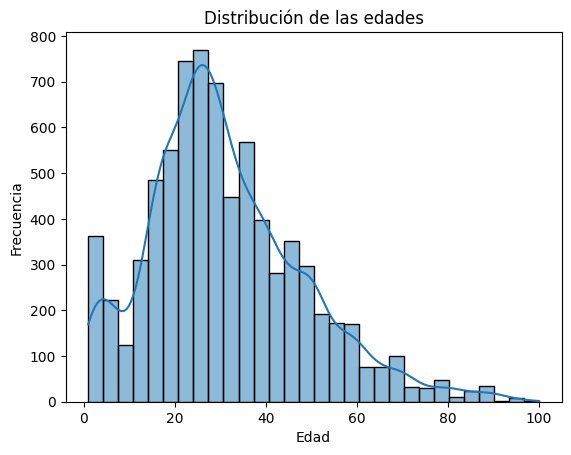

In [4]:
# Histograma con línea KDE (densidad suavizada)
sns.histplot(labels['real_age'], bins=30, kde=True)

plt.title('Distribución de las edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

* La mayoría de las personas en el conjunto de datos se encuentra en un rango de edad joven, con un pico alrededor de los 20 años.

* La distribución es asimétrica, con una larga cola hacia la derecha, lo que indica que hay menos personas mayores, pero algunos individuos alcanzan edades más avanzadas.

* La curva KDE suaviza la distribución, mostrando una concentración alta de edades entre los 15 y 30 años.

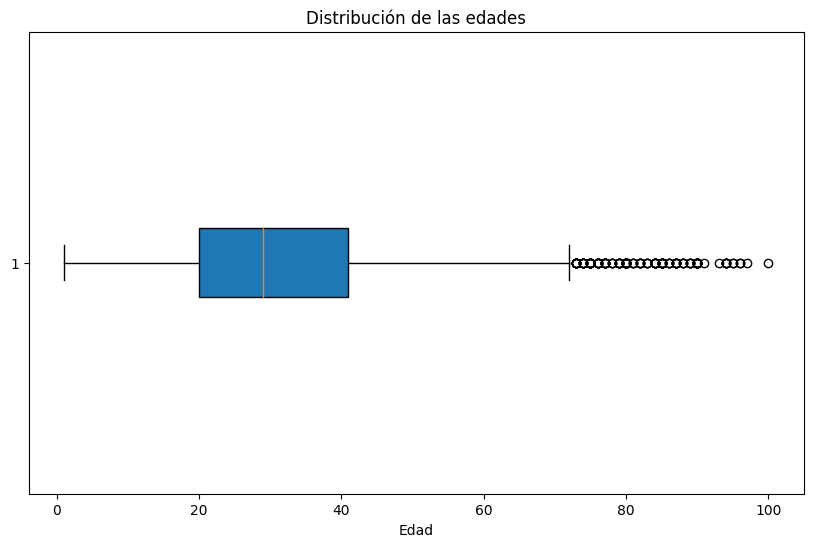

In [5]:
# Distribución de edades con boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(labels['real_age'], vert=False, patch_artist=True)
plt.title('Distribución de las edades')
plt.xlabel('Edad')
plt.show()

* El boxplot confirma la distribución asimétrica observada en el histograma, mostrando una mediana (línea dentro de la caja) alrededor de los 30 años.

* Existen varios valores atípicos (outliers) en el extremo derecho (mayores de 60 años), que representan personas significativamente más viejas que la mayoría de la población.

* La caja (que representa el rango intercuartil) indica que la mayoría de las edades están concentradas entre 20 y 40 años.

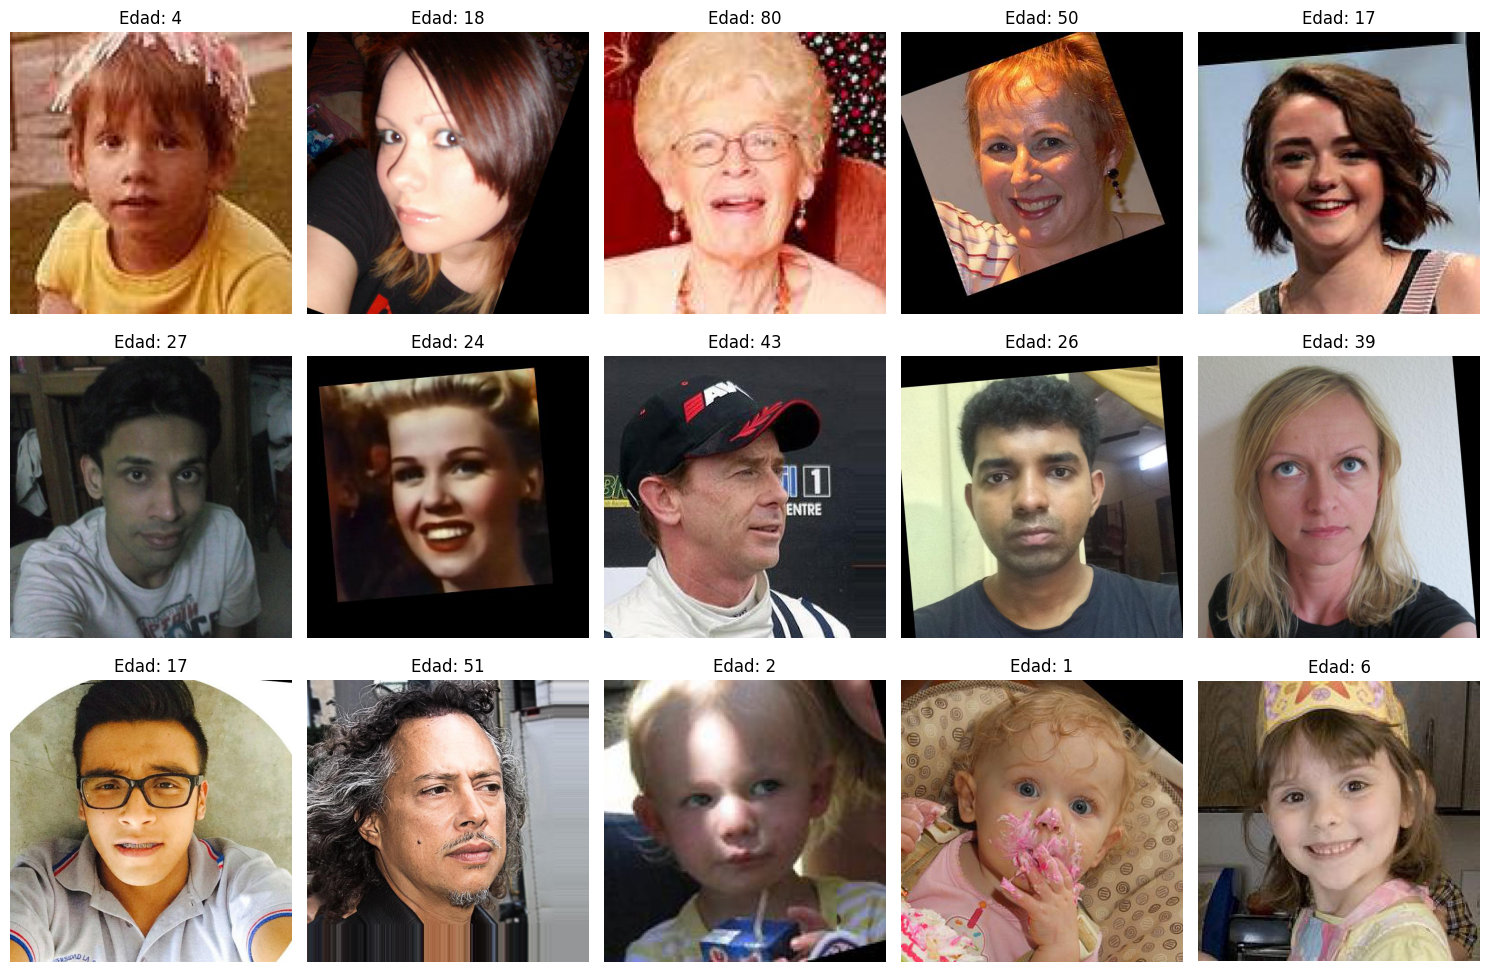

In [6]:
# Mostrar algunas imágenes con las edades correspondientes
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    img_path = path + 'final_files/' + labels.iloc[i]['file_name']
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Edad: {labels.iloc[i]['real_age']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Conclusiones

* El conjunto de datos está sesgado hacia los jóvenes, con un número significativo de individuos menores de 40 años y algunos valores atípicos de personas mayores, lo que se refleja tanto en el histograma como en el boxplot.
<br>

* Este sesgo podría influir en el rendimiento del modelo predictivo, ya que el modelo puede estar más ajustado para predecir correctamente las edades jóvenes que las edades avanzadas.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [7]:
# 1. Función para cargar datos de entrenamiento
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    # Convertir el flujo en un dataset y aplicar .repeat()
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_gen_flow,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    
    # Aplicar repeat para evitar que se queden sin datos
    train_dataset = train_dataset.repeat()
    
    return train_dataset

In [8]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    # Convertir el flujo en un dataset y aplicar .repeat()
    test_dataset = tf.data.Dataset.from_generator(
        lambda: test_gen_flow,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    
    # Aplicar repeat para evitar que se queden sin datos
    test_dataset = test_dataset.repeat()
    
    return test_dataset

In [9]:
# 3. Crear el modelo basado en ResNet50
def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Una sola salida para predecir la edad
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    return model

In [10]:
# 4. Función para entrenar el modelo y mostrar resultados con EarlyStopping monitoreando MAE (EAM)
def train_model(model, train_data, test_data, batch_size=32, epochs=20, steps_per_epoch=None, validation_steps=None):
    
    # Implementar EarlyStopping para monitorizar MAE (EAM)
    early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

    # Entrenamiento con EarlyStopping
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping]  # Agregar EarlyStopping como callback
    )
    
    # Evaluar el modelo en el conjunto de validación
    val_loss, val_mae = model.evaluate(test_data, steps=validation_steps)
    print(f'Pérdida en validación (loss): {val_loss}')
    print(f'EAM en validación: {val_mae}')  # Imprimir el MAE (EAM)
    
    return model

In [11]:
# 1. Cargar los datos de entrenamiento
train_gen_flow = load_train(path)

Found 6073 validated image filenames.


2025-02-22 13:26:30.259582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# 2. Cargar los datos de validación
test_gen_flow = load_test(path)

Found 1897 validated image filenames.


In [13]:
# 3. Crear el modelo
model = create_model()

In [ ]:
# 4. Entrenar el modelo con los datos cargados
model = train_model(model, train_gen_flow, test_gen_flow, epochs=3, steps_per_epoch=500, validation_steps=100)

Epoch 1/3


## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# 5. Crear el archivo script para la ejecución en GPU
init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

**Epoch 1/3**
500/500 ━━━━━━━━━━━━━━━━━━━━ 2676s 5s/step - loss: 255.8637 - mae: 11.4545 - val_loss: 347.3177 - val_mae: 13.9130

**Epoch 2/3**
500/500 ━━━━━━━━━━━━━━━━━━━━ 2493s 5s/step - loss: 51.5140 - mae: 5.3909 - val_loss: 76.7359 - val_mae: 6.5046

**Epoch 3/3**
500/500 ━━━━━━━━━━━━━━━━━━━━ 2509s 5s/step - loss: 36.1527 - mae: 4.5465 - val_loss: 66.5533 - val_mae: 6.1465
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 72.5668 - mae: 6.3609

**Pérdida en validación (loss)**: 69.517333984375

**EAM en validación**: 6.238131999969482

## Conclusiones

__1. Mejora en el rendimiento a lo largo de las épocas__:

- En la **primera época**, el modelo comenzó con un **MAE** de **11.45** en el conjunto de entrenamiento y **13.91** en el conjunto de validación. Estos valores indican un rendimiento inicial relativamente pobre, lo que es normal en las primeras épocas, ya que el modelo está comenzando a aprender las características de los datos.
<br>

- En la **segunda época**, el MAE en el conjunto de entrenamiento mejoró significativamente a **5.39**, mientras que el MAE en el conjunto de validación bajó a **6.50**. Esto demuestra que el modelo está aprendiendo rápidamente y mejorando su capacidad de generalización.
<br>

- En la **tercera época**, el **MAE** en entrenamiento mejoró aún más, disminuyendo a **4.54**, y el **MAE** en validación se redujo a **6.14**. El modelo sigue mejorando en su capacidad para predecir la edad.

__2. Estabilización de la pérdida (loss) y MAE en validación__:

- Aunque el MAE en validación mejoró notablemente entre la primera y la segunda época, la mejora en la tercera época fue más moderada. Esto sugiere que el modelo podría estar acercándose a su límite de rendimiento en este conjunto de datos.
<br>

- El **MAE** final en validación es **6.23**, lo que representa una mejora considerable con respecto a las épocas anteriores y es un buen resultado, dependiendo del objetivo del proyecto.

__3. Buen rendimiento general, pero espacio para mejorar__:

- Un MAE de **6.23** en el conjunto de validación significa que el modelo tiene un **error absoluto medio de aproximadamente 6 años** al predecir la edad de las personas en las imágenes. Este es un resultado satisfactorio, pero si el objetivo es lograr un **MAE** menor de 5, aún hay margen para mejorar.

__4. Posible sobreajuste__:

- La diferencia relativamente pequeña entre el **MAE** en entrenamiento y validación en la última época (4.54 vs. 6.14) sugiere que el modelo no está sobreajustado. No obstante, es importante monitorear este aspecto en futuras épocas.
<br>

- El **EarlyStopping** podría detener el entrenamiento antes de que ocurra sobreajuste, asegurando que el modelo no entrene más allá de lo necesario.

__5. Sugerencias para mejorar__:

- **Aumentar número de épocas**: Dado que el modelo sigue mejorando, podría ser beneficioso entrenar por más épocas y continuar monitoreando el **MAE**.
<br>

- **Ajustar la tasa de aprendizaje**: Reducir la tasa de aprendizaje puede ayudar a afinar las predicciones y a reducir aún más el **MAE** en las últimas etapas de entrenamiento.
<br>

- **Aplicar más técnicas de aumento de datos**: Esto puede mejorar la capacidad de generalización del modelo, especialmente si el conjunto de validación deja de mejorar.
<br>

- **Explorar técnicas de regularización**: Si el modelo comienza a sobreajustarse, se podrían aplicar técnicas de regularización como **L2 regularization** o aumentar el **Dropout**.

### Conclusión:

El modelo ha mostrado una mejora significativa en el entrenamiento y ha alcanzado un **MAE** de **6.23** en el conjunto de validación, lo cual es un buen resultado, pero podría mejorarse más si se ajustan algunos parámetros o se entrena por más épocas. 